In [1]:
# !pip install IPython
from IPython.display import Image

In [ ]:
!git clone https://github.com/Im-JihyunKim/2023_LG_ES_SSL_1.git # colab 사용시

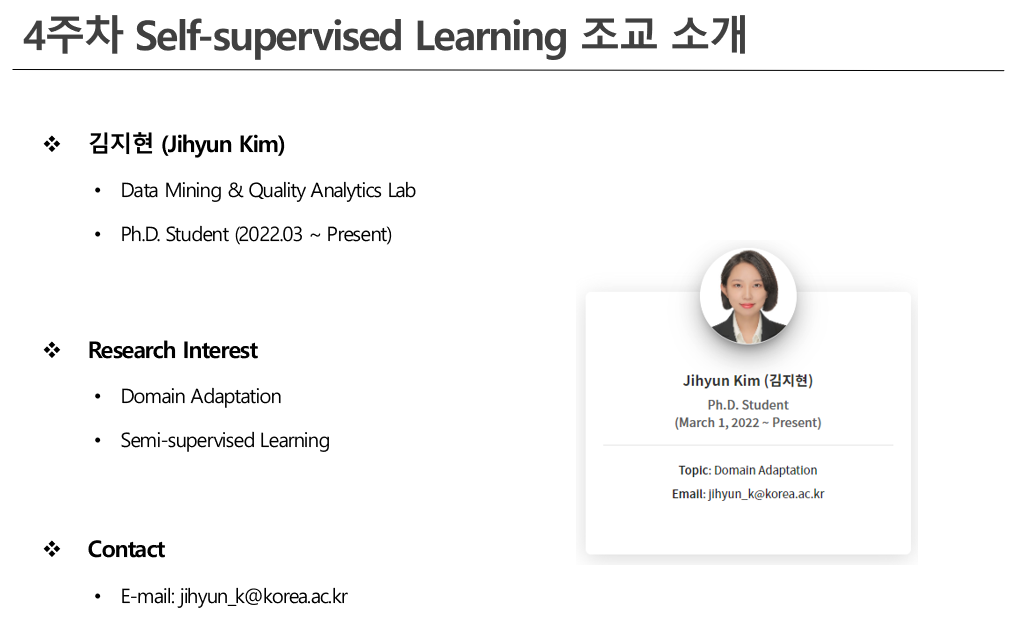

In [2]:
# Image('image/image1.PNG') # 로컬 사용시
Image('/content/2023_LG_ES_SSL_1/image/image1.PNG') # colab 사용시

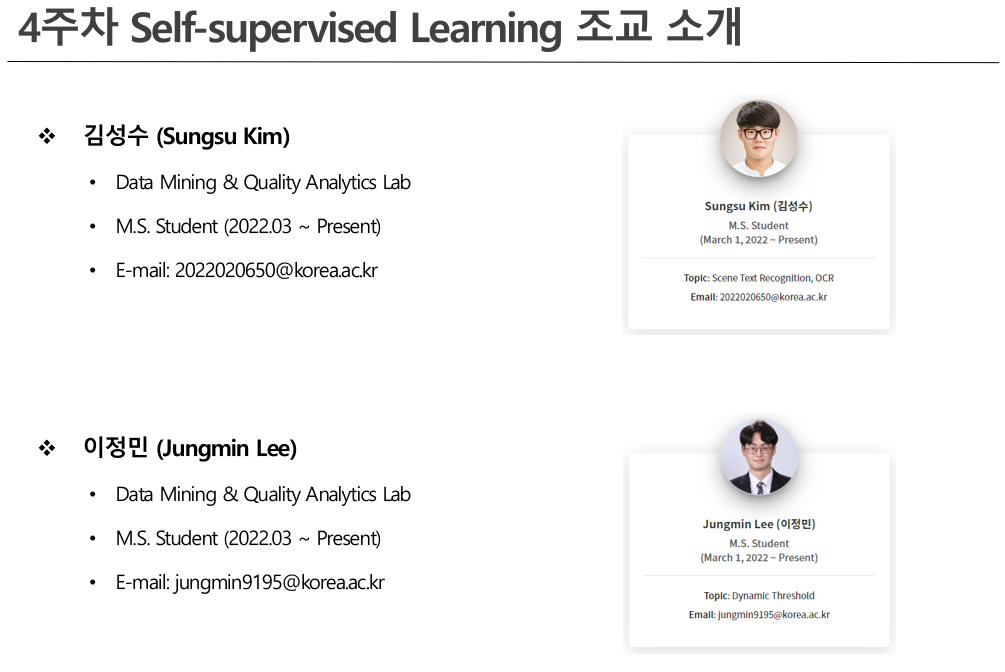

In [3]:
# Image('image/image2.PNG') # 로컬 사용시
Image('/content/2023_LG_ES_SSL_1/image/image2.PNG') # colab 사용시

-----------

# [Self-supervised Learning] AutoEncoder-Based Pretext Task

##### jupyter notebook 단축키

- ctrl+enter: 셀 실행   
- shift+enter: 셀 실행 및 다음 셀 이동   
- alt+enter: 셀 실행, 다음 셀 이동, 새로운 셀 생성
- a: 상단에 새로운 셀 만들기
- b: 하단에 새로운 셀 만들기
- dd: 셀 삭제(x: 셀 삭제)

## 1. 모듈 불러오기

In [2]:
import os, random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader, Subset  # Dataset과 dataloader를 기반으로 미니배치 학습, 데이터 셔플, 병렬 처리까지 간단하게 수행 가능하도록 지원
from torchvision.transforms import transforms
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
plt.set_cmap('cividis')
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings(action='ignore')

c:\Users\JihyunKim\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Figure size 640x480 with 0 Axes>

In [3]:
'''
seed 정의
https://hoya012.github.io/blog/reproducible_pytorch/
'''
random_seed = 2023
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

## 2. Custom Dataset 정의
- 방대한 데이터를 batch 단위로 쪼개서 불러올 수 있도록 정의해주는 과정 (기존에는 모든 데이터셋을 한꺼번에 처리)
- Custom Dataset은 가변 길이 input이나 batch를 만들어줄 때 필요  
- 본 튜토리얼에서는 증강된 이미지도 함께 불러와야 하기에 이를 가져올 수 있는 Custom Dataset을 정의할 것임  
cf. https://didu-story.tistory.com/85

### CIFAR10 Dataset

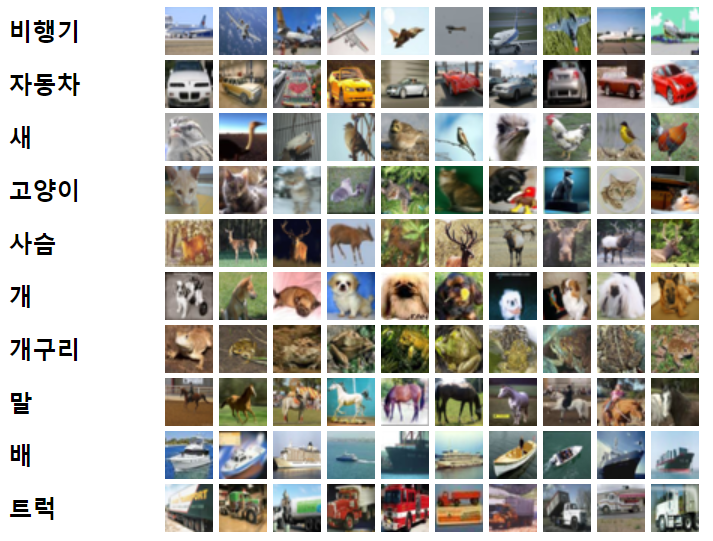

In [6]:
# Image('image/cifar10.PNG') # 로컬 사용시
Image('/content/2023_LG_ES_SSL_1/image/cifar10.PNG') # colab 사용시

- 32x32의 RGB 이미지로 구성된 데이터셋
  - 총 60,000개의 데이터가 있으며 일반적으로 50,000개는 학습용, 10,000개는 테스트용으로 구분해서 사용
  - 본 튜토리얼에서는 50,000개의 학습용 이미지를 Pretraining Task에서, 10,000개의 테스트용 이미지를 Downstream Task에 활용
    - 10,000개의 Downstream Task용 이미지는 8,000개의 Train과 2,000개의 Test 데이터로 구분됨 (Validation Dataset은 따로 지정하지 않음)
- 10개의 class를 분류하는 image classification task에 주로 활용

In [4]:
# Custom Dataset
class CIFAR10Dataset(Dataset):
    def __init__(self, data_dir:str):
        self.data_dir = data_dir

        # 저장 경로 폴더가 없는 경우 만들어주어야 함
        os.makedirs(data_dir, exist_ok=True)

    # For Self-supervised Learning
    def get_pretrain_dataset(self):
        pretrain_dataset = datasets.CIFAR10(self.data_dir, 
                                            train=True,  # train 여부
                                            transform=transforms.Compose([
                                                        transforms.ToTensor(),    # 이미지를 tensor 타입으로 바꾸어줌
                                                        transforms.Normalize(      # 이미지 데이터 내의 값을 정규화 (역전파 단계에서 gradient 계산 시 데이터마다 유사한 범위의 값을 가지도록 하기 위함)
                                                                mean=(0.4914, 0.4822, 0.4465),
                                                                std=(0.2023, 0.1994, 0.2010))
                                                                ]),
                                            download=True)
        return pretrain_dataset
        
    
    # For Downstream task : 지도학습에 사용되는 데이터
    def get_dataset(self, mode:str='train'):
        downstream_dataset = datasets.CIFAR10(self.data_dir,
                                             train=False,   # train 여부
                                             transform=transforms.Compose([
                                                        transforms.ToTensor(),    # 이미지를 tensor 타입으로 바꾸어줌
                                                        transforms.Normalize(      # 이미지 데이터 내의 값을 정규화 (역전파 단계에서 gradient 계산 시 데이터마다 유사한 범위의 값을 가지도록 하기 위함)
                                                                mean=(0.4914, 0.4822, 0.4465),
                                                                std=(0.2023, 0.1994, 0.2010))
                                                                ]),
                                             download=True)
        train_idx, test_idx = train_test_split(list(range(len(downstream_dataset))), test_size=0.2, random_state=2023)

        if mode == 'train':
            train_dataset = Subset(downstream_dataset, train_idx)  # 8,000개
            return train_dataset
        
        elif mode == 'test':
            test_dataset = Subset(downstream_dataset, test_idx)    # # 2,000개
            return test_dataset
        
        else:
            raise NotImplementedError("'mode' should be one of ['train' or 'test']")

### cf. CIFAR 10 원본 이미지

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


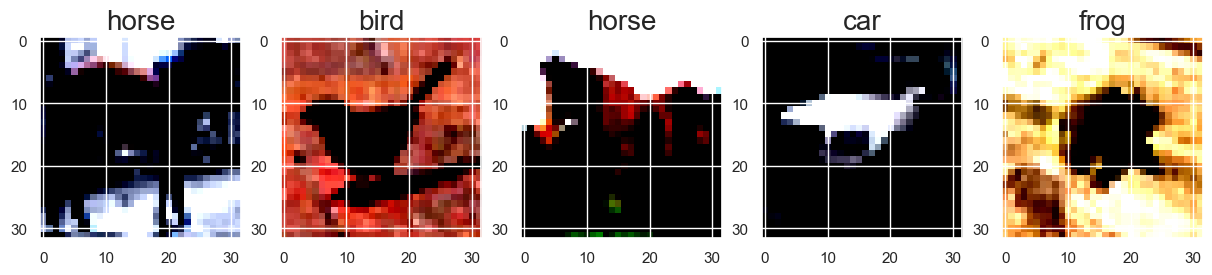

In [5]:
data_dir = './data/'
# data_dir = '/content/2023_LG_ES_SSL_1/data/'   # colab 사용 시

Cifar10 = CIFAR10Dataset(data_dir)
Cifar10_train = Cifar10.get_dataset()
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

train_loader = DataLoader(
        dataset=Cifar10_train,
        batch_size=5,
        shuffle=True,
        num_workers=0,
        drop_last=False)
images, labels = next(iter(train_loader))

fig = plt.figure(figsize=(15,3))
for i, img, label in zip(range(5), images, labels):
    numpy_img = np.transpose(img.numpy(), (1, 2, 0))
    ax = fig.add_subplot(1, 5, i+1)
    ax.imshow(numpy_img)
    title = classes[int(label)]
    ax.set_title(title, fontsize=20)
plt.show()

## 3. AutoEncoder 네트워크 정의
* Convolution AutoEncoder

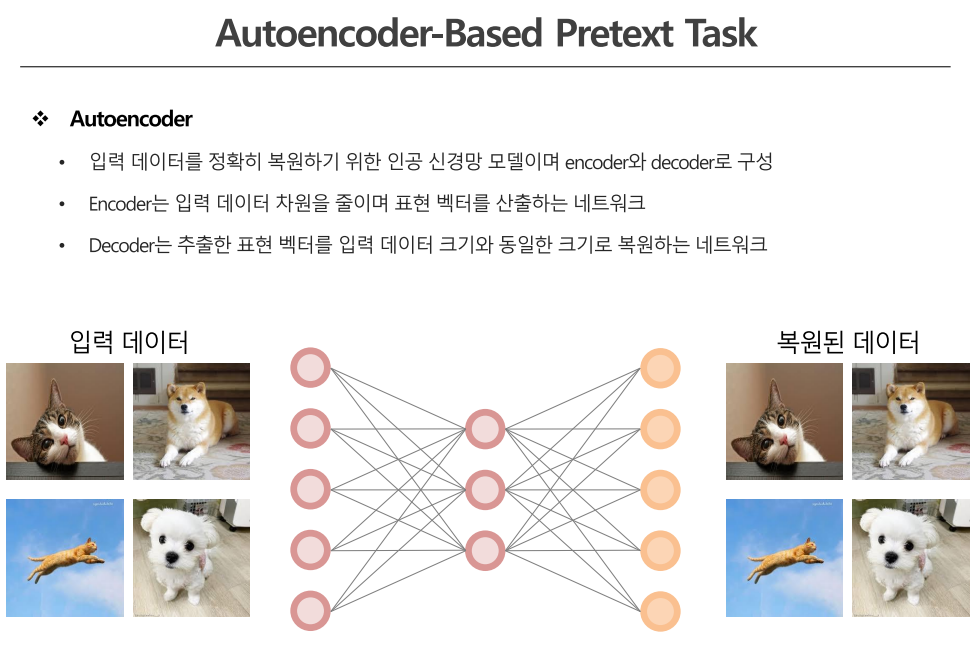

In [11]:
# Image('image/AE.PNG') # 로컬 사용시
Image('/content/2023_LG_ES_SSL_1/image/AE.PNG') # colab 사용시

In [6]:
class Convolution_AE(nn.Module):
    def __init__(self):
        super(Convolution_AE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=12, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(24, 48, 4, stride=2, padding=1), 
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),
            nn.Sigmoid()   # 픽셀당 0과 1 사이로 값을 출력
            )
        
    def forward(self, x: torch.Tensor):
        enc_out = self.encoder(x)
        dec_out = self.decoder(enc_out)

        return dec_out

## 4. Convolution AutoEncoder 학습 정의

In [7]:
class ConvAE_Trainer(object):
    def __init__(self, device, model, **kwargs):
        self.device = device
        self.model = model.to(device)
        self.criterion = nn.MSELoss()
        self.__dict__.update(kwargs)

    def pretrain(self, train_loader):

        for epoch in range(self.epochs+1):
            running_loss, running_total = 0.0, 0
            for images, _ in train_loader:
                images = images.to(self.device)

                outputs = self.model(images)
                loss = self.criterion(outputs, images)
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item() * images.size(0)
                running_total += images.size(0)

            epoch_loss = running_loss / running_total

            if epoch == 0 or (epoch + 1) % 5 == 0:
                print('Epoch: {} Loss: {:.4f}'.format(epoch+1, epoch_loss))

        return self.model

## 5. Convolution AutoEndoer 코드 실행

In [25]:
def main(device, configs:dict):

    # define dataset, dataloader
    dataset = CIFAR10Dataset(data_dir=configs['data_dir']) 
    train_dataset = dataset.get_pretrain_dataset()
    train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=configs['batch_size'],
            shuffle=True,
            num_workers=configs['num_worker'],
            drop_last=True)
    
    # definde optimizer
    model = Convolution_AE()

    optimizer = torch.optim.Adam(
        model.parameters(), 
        lr=configs['learning_rate'], 
        weight_decay=configs['weight_decay'])
    

    trainer = ConvAE_Trainer(device=device, 
                             model=model, 
                             optimizer=optimizer,
                             batch_size = configs['batch_size'],
                             epochs = configs['epochs'],
                             )
    
    pretrained_model = trainer.pretrain(train_loader=train_loader)

    return pretrained_model


if __name__ == '__main__':
    device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
    configs = {'data_dir': './data/',  # local: './data/' or colab:'/content/2023_LG_ES_SSL_1/data/'
               'batch_size': 256, 'epochs': 50, 
               'learning_rate': 3e-4, 'weight_decay':0, 'num_worker': 0}
    
    pretrained_model = main(device, configs)

Files already downloaded and verified
Epoch: 1 Loss: 1.4027
Epoch: 5 Loss: 1.0127
Epoch: 10 Loss: 0.9656
Epoch: 15 Loss: 0.9525
Epoch: 20 Loss: 0.9467
Epoch: 25 Loss: 0.9424
Epoch: 30 Loss: 0.9394
Epoch: 35 Loss: 0.9373
Epoch: 40 Loss: 0.9355
Epoch: 45 Loss: 0.9341
Epoch: 50 Loss: 0.9326
Epoch: 55 Loss: 0.9305
Epoch: 60 Loss: 0.9288
Epoch: 65 Loss: 0.9279
Epoch: 70 Loss: 0.9274
Epoch: 75 Loss: 0.9269
Epoch: 80 Loss: 0.9264
Epoch: 85 Loss: 0.9260
Epoch: 90 Loss: 0.9255
Epoch: 95 Loss: 0.9249
Epoch: 100 Loss: 0.9244


### 재구축이 잘 되었는지 확인

__1. Testset 원본 이미지__

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


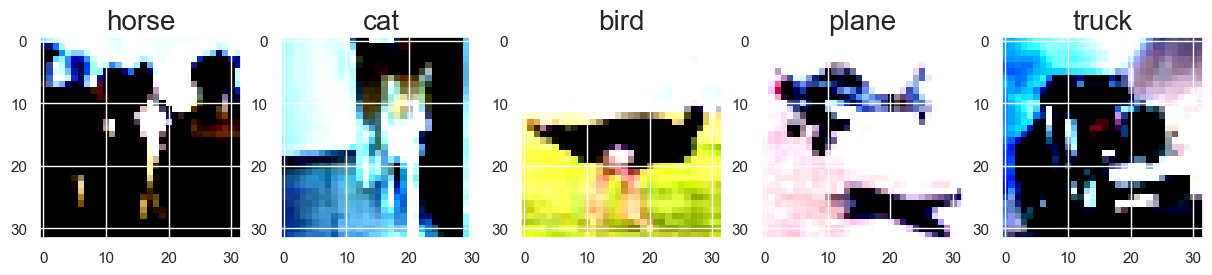

In [26]:
data_dir = './data/'
# data_dir = '/content/2023_LG_ES_SSL_1/data/'   # colab 사용 시

Cifar10 = CIFAR10Dataset(data_dir)
Cifar10_test = Cifar10.get_dataset(mode='test')
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

test_loader = DataLoader(
        dataset=Cifar10_test,
        batch_size=5,
        shuffle=False,
        num_workers=0,
        drop_last=False)
images, labels = next(iter(test_loader))

fig = plt.figure(figsize=(15,3))
for i, img, label in zip(range(5), images, labels):
    numpy_img = np.transpose(img.detach().numpy(), (1, 2, 0))
    ax = fig.add_subplot(1, 5, i+1)
    ax.imshow(numpy_img)
    title = classes[int(label)]
    ax.set_title(title, fontsize=20)
plt.show()

__2. 재구축된 Testset 이미지__

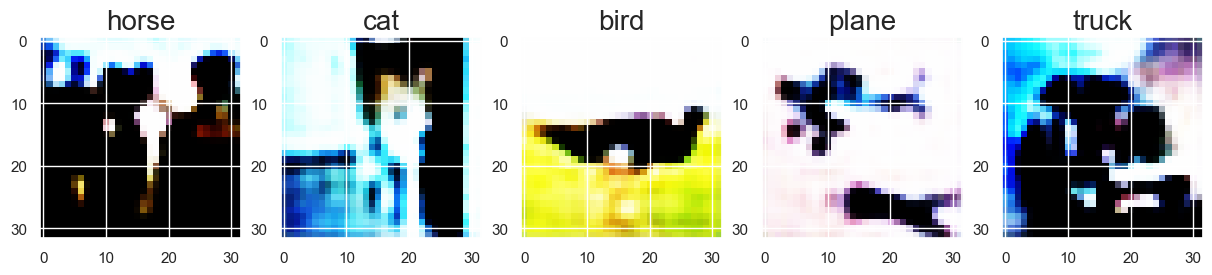

In [27]:
test_output = pretrained_model(images.to('cuda:0')).cpu()

fig = plt.figure(figsize=(15,3))
for i, img, label in zip(range(5), test_output, labels):
    numpy_img = np.transpose(img.detach().numpy(), (1, 2, 0))
    ax = fig.add_subplot(1, 5, i+1)
    ax.imshow(numpy_img)
    title = classes[int(label)]
    ax.set_title(title, fontsize=20)
plt.show()

## 사전학습 된 Encoder를 이용하여 Downstream Task 수행
- Transfer Learning(전이 학습)의 개념
- 사전학습 된 인코더를 활용하여 Supervised Learning 수행

In [28]:
def accuracy(output: torch.FloatTensor,
             target: torch.LongTensor,
             topk: tuple=(1, )):
    """
    Computes the accuracy over the top k predictions
    for the specified values of k
    - Top-1 Accuracy: softmax의 output에서 제일 높은 수치(confidence)를 가지는 확롤 값이 실제 정답일 경우에 대한 지표 계산
    - Top-n Accuracy : softmax output 중 상위 n개의 확률 값을 가진느 클래스 중 실제 정답이 있는 경우에 대한 지표 계산
    """
    with torch.no_grad():
        max_k = max(topk)
        batch_size = target.size(0)
        _, pred = output.topk(max_k, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        
        return res

In [29]:
class Downstream(object):
    def __init__(self, device, encoder, classifier, optimizer, **kwargs):
        self.device = device

        self.encoder = encoder.to(device)
        self.classifier = classifier.to(device)
        self.optimizer = optimizer

        self.criterion = nn.CrossEntropyLoss().to(device)
        self.__dict__.update(kwargs)

    def train_test(self, train_loader, test_loader):

        for epoch in range(self.epochs):
            # Train
            top1_train_acc, train_loss = 0, 0
            for i, (images, targets) in enumerate(train_loader):
                images = images.to(self.device)
                targets = targets.to(self.device)

                # Freeze Encoder Parameters (사전학습된 인코더의 파라미터는 업데이트 하지 않음!)
                with torch.no_grad():
                    features = self.encoder(images)
                    features = features.view(features.size(0), -1)  # flattten

                logits = self.classifier(features)
                loss = self.criterion(logits, targets)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                top1 = accuracy(logits, targets, topk=(1, ))
                top1_train_acc += top1[0]
                
                train_loss += loss

            top1_train_acc /= (i + 1)
            train_loss /= (i + 1)

            # Test
            top1_test_acc, top5_test_acc = 0, 0
            for i, (images, targets) in enumerate(test_loader):
                images = images.to(self.device)
                targets = targets.to(self.device)

                with torch.no_grad():
                    features = self.encoder(images)
                    features = features.view(features.size(0), -1)  # flattten
                    logits = self.classifier(features)

                top1, top5 = accuracy(logits, targets, topk=(1, 5))
                top1_test_acc += top1[0]
                top5_test_acc += top5[0]

            top1_test_acc /= (i + 1)
            top5_test_acc /= (i + 1)

            print(f'Epoch: {epoch + 1} \n'
                  f'Loss: {train_loss} \n'
                  f'Top1 Train Accuracy: {top1_train_acc.item()} \n'
                  f'Top1 Test Accuracy: {top1_test_acc.item()} \n'
                  f'Top5 Test Accuracy: {top5_test_acc.item()} \n')
        
        return self.encoder, self.classifier

In [30]:
def main(device, configs: dict):
    
    # Define Dataset, Dataloader
    dataset = CIFAR10Dataset(data_dir=configs['data_dir'])   # local: './data/' or colab:'/content/2023_LG_ES_SSL_1/data/',
    
    train_dataset = dataset.get_dataset(mode='train')
    test_dataset = dataset.get_dataset(mode='test')
    
    train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=configs['batch_size'],
            shuffle=True,
            num_workers=configs['num_worker'],
            drop_last=False)
    
    test_loader = DataLoader(
            dataset=test_dataset,
            batch_size=configs['batch_size'],
            shuffle=False,
            num_workers=configs['num_worker'],
            drop_last=False)
    
    # Define encoder, optimizer, linear classifier
    encoder = pretrained_model.encoder
    
    classifier = nn.Sequential(
        nn.Linear(768, 512),
        nn.ReLU(),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Linear(128, configs['num_class'])
    )

    optimizer = torch.optim.Adam(
        classifier.parameters(), 
        lr=configs['learning_rate'], 
        weight_decay=configs['weight_decay'])
    
    downstream = Downstream(
        device = device,
        encoder=encoder,
        classifier=classifier,
        optimizer=optimizer,
        epochs=configs['epochs'])
    
    supervised_encoder, supervised_classifier = downstream.train_test(train_loader=train_loader,
                                                                        test_loader=test_loader)
    
    return supervised_encoder, supervised_classifier


if __name__ == '__main__':
    device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu') 
    configs = {'data_dir': './data/',  # local: './data/' or colab:'/content/2023_LG_ES_SSL_1/data/'
               'batch_size': 256, 'epochs': 10,
               'learning_rate': 3e-4, 'weight_decay':0,
               'num_class': 10, 'num_worker': 0}
    supervised_model = main(device, configs)

Files already downloaded and verified
Files already downloaded and verified
Epoch: 1 
Loss: 2.1907219886779785 
Top1 Train Accuracy: 20.01953125 
Top1 Test Accuracy: 25.29296875 
Top5 Test Accuracy: 74.54927825927734 

Epoch: 2 
Loss: 2.002028465270996 
Top1 Train Accuracy: 28.13720703125 
Top1 Test Accuracy: 30.363582611083984 
Top5 Test Accuracy: 78.48933410644531 

Epoch: 3 
Loss: 1.925446629524231 
Top1 Train Accuracy: 32.33642578125 
Top1 Test Accuracy: 32.88386535644531 
Top5 Test Accuracy: 81.15985870361328 

Epoch: 4 
Loss: 1.8877604007720947 
Top1 Train Accuracy: 33.19091796875 
Top1 Test Accuracy: 33.07542037963867 
Top5 Test Accuracy: 82.29417419433594 

Epoch: 5 
Loss: 1.8520705699920654 
Top1 Train Accuracy: 34.70458984375 
Top1 Test Accuracy: 34.656700134277344 
Top5 Test Accuracy: 81.29131317138672 

Epoch: 6 
Loss: 1.8193782567977905 
Top1 Train Accuracy: 35.9130859375 
Top1 Test Accuracy: 37.56385040283203 
Top5 Test Accuracy: 83.85667419433594 

Epoch: 7 
Loss: 1.7871

------

## [비교] AutoEncoder로 사전학습을 수행하지 않고, 단순히 지도학습(Supervised Learning)만 적용한 경우

In [24]:
def main(device, configs: dict):
    
    # Define Dataset, Dataloader
    dataset = CIFAR10Dataset(data_dir=configs['data_dir'])   # local: './data/' or colab:'/content/2023_LG_ES_SSL_1/data/',
    
    train_dataset = dataset.get_dataset(mode='train')
    test_dataset = dataset.get_dataset(mode='test')
    
    train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=configs['batch_size'],
            shuffle=True,
            num_workers=configs['num_worker'],
            drop_last=False)
    
    test_loader = DataLoader(
            dataset=test_dataset,
            batch_size=configs['batch_size'],
            shuffle=False,
            num_workers=configs['num_worker'],
            drop_last=False)
    
    # Define encoder, optimizer, linear classifier
    encoder = Convolution_AE().encoder
    
    classifier = nn.Sequential(
        nn.Linear(768, 512),
        nn.ReLU(),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Linear(128, configs['num_class'])
    )

    optimizer = torch.optim.Adam(
        classifier.parameters(), 
        lr=configs['learning_rate'], 
        weight_decay=configs['weight_decay'])
    
    downstream = Downstream(
        device = device,
        encoder=encoder,
        classifier=classifier,
        optimizer=optimizer,
        epochs=configs['epochs'])
    
    supervised_encoder, supervised_classifier = downstream.train_test(train_loader=train_loader,
                                                                        test_loader=test_loader)
    
    return supervised_encoder, supervised_classifier


if __name__ == '__main__':
    device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu') 
    configs = {'data_dir': './data/',  # local: './data/' or colab:'/content/2023_LG_ES_SSL_1/data/'
               'batch_size': 256, 'epochs': 10, 
               'learning_rate': 3e-4, 'weight_decay':0,
               'num_class': 10, 'num_worker': 0}
    supervised_model = main(device, configs)

Files already downloaded and verified
Files already downloaded and verified
Epoch: 1 
Loss: 2.266653537750244 
Top1 Train Accuracy: 16.80908203125 
Top1 Test Accuracy: 24.4140625 
Top5 Test Accuracy: 71.70597839355469 

Epoch: 2 
Loss: 2.1301398277282715 
Top1 Train Accuracy: 26.6357421875 
Top1 Test Accuracy: 29.308143615722656 
Top5 Test Accuracy: 77.40009307861328 

Epoch: 3 
Loss: 1.9932914972305298 
Top1 Train Accuracy: 29.0771484375 
Top1 Test Accuracy: 31.734525680541992 
Top5 Test Accuracy: 80.97956848144531 

Epoch: 4 
Loss: 1.8943175077438354 
Top1 Train Accuracy: 32.958984375 
Top1 Test Accuracy: 33.84164810180664 
Top5 Test Accuracy: 83.34585571289062 

Epoch: 5 
Loss: 1.8270561695098877 
Top1 Train Accuracy: 34.5703125 
Top1 Test Accuracy: 36.42202377319336 
Top5 Test Accuracy: 84.81820678710938 

Epoch: 6 
Loss: 1.777073860168457 
Top1 Train Accuracy: 37.1826171875 
Top1 Test Accuracy: 37.81925964355469 
Top5 Test Accuracy: 85.04732513427734 

Epoch: 7 
Loss: 1.7395116090

------

## Denoising AutoEncoder
- 학습을 할때 입력에 잡음을 더하는 방식으로 복원 능력을 강화
- 앞서 다룬 코드와 동일하며 `add_noise()` 함수로 학습시 이미지에 노이즈를 더해주는 부분만 추가

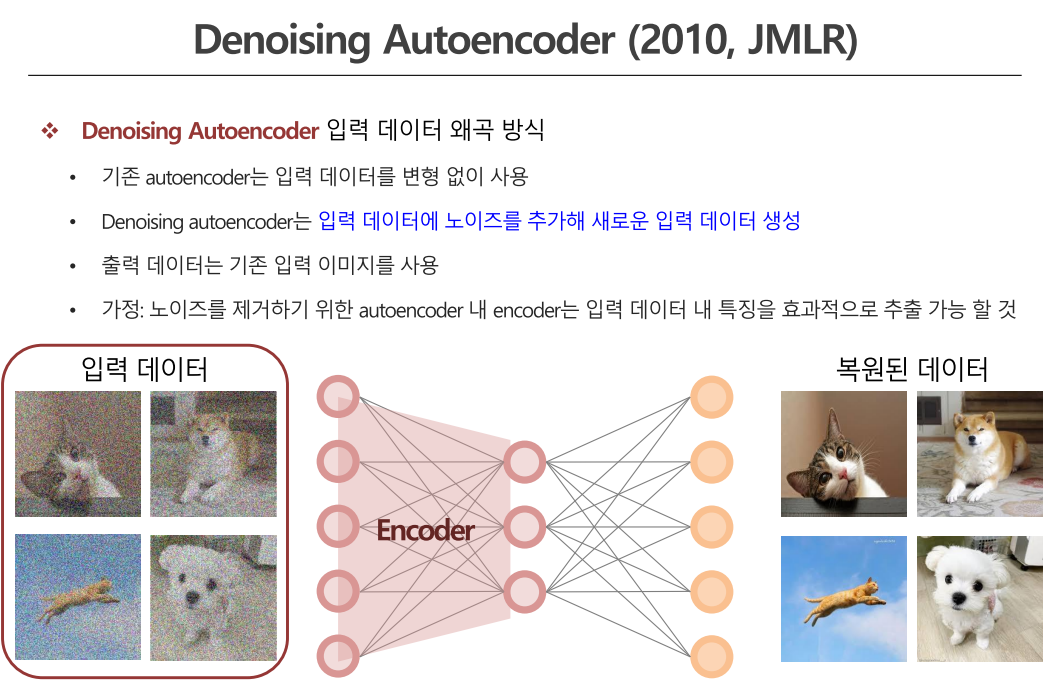

In [65]:
# Image('image/DenoisingAE.PNG') # 로컬 사용시
Image('/content/2023_LG_ES_SSL_1/image/DenoisingAE.PNG') # colab 사용시

In [31]:
def add_noise(img):
    noise = torch.randn(img.size()) * 0.2
    noisy_img = img + noise
    return noisy_img

### 노이즈가 추가된 이미지 확인

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


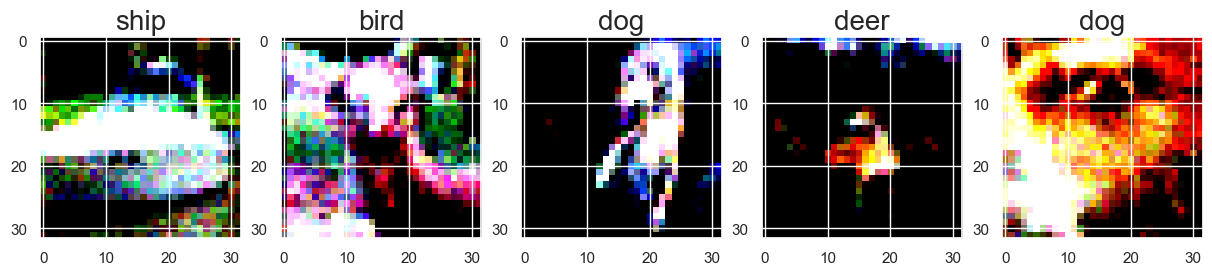

In [32]:
data_dir = './data/'
# data_dir = '/content/2023_LG_ES_SSL_1/data/'   # colab 사용 시

Cifar10 = CIFAR10Dataset(data_dir)
Cifar10_train = Cifar10.get_dataset()
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

train_loader = DataLoader(
        dataset=Cifar10_train,
        batch_size=5,
        shuffle=True,
        num_workers=0,
        drop_last=False)
images, labels = next(iter(train_loader))

fig = plt.figure(figsize=(15,3))
for i, img, label in zip(range(5), add_noise(images), labels):
    numpy_img = np.transpose(img.numpy(), (1, 2, 0))
    ax = fig.add_subplot(1, 5, i+1)
    ax.imshow(numpy_img)
    title = classes[int(label)]
    ax.set_title(title, fontsize=20)
plt.show()

In [33]:
class Denoising_ConvAE_Trainer(object):
    def __init__(self, device, model, **kwargs):
        self.device = device
        self.model = model.to(device)
        self.criterion = nn.MSELoss()
        self.__dict__.update(kwargs)

    def pretrain(self, train_loader):

        for epoch in range(self.epochs+1):
            running_loss, running_total = 0.0, 0
            for images, _ in train_loader:
                images = add_noise(images).to(self.device)

                outputs = self.model(images)
                loss = self.criterion(outputs, images)
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item() * images.size(0)
                running_total += images.size(0)

            epoch_loss = running_loss / running_total

            if epoch == 0 or (epoch + 1) % 5 == 0:
                print('Epoch: {} Loss: {:.4f}'.format(epoch+1, epoch_loss))

        return self.model

In [35]:
def main(device, configs:dict):

    # define dataset, dataloader
    dataset = CIFAR10Dataset(data_dir='./data/')   # local: './data/' or colab:'/content/2023_LG_ES_SSL_1/data/'
    train_dataset = dataset.get_pretrain_dataset()
    train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=configs['batch_size'],
            shuffle=True,
            num_workers=configs['num_worker'],
            drop_last=True)
    
    # definde optimizer
    model = Convolution_AE()

    optimizer = torch.optim.Adam(
        model.parameters(), 
        lr=configs['learning_rate'], 
        weight_decay=configs['weight_decay'])
    

    trainer = Denoising_ConvAE_Trainer(device=device, 
                                    model=model, 
                                    optimizer=optimizer,
                                    batch_size = configs['batch_size'],
                                    epochs = configs['epochs'],
                                    )
    
    pretrained_model = trainer.pretrain(train_loader=train_loader)

    return pretrained_model

if __name__ == '__main__':
    device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
    configs = {'batch_size': 256, 'epochs': 50, 
               'learning_rate': 3e-4, 'weight_decay':0, 'num_worker': 0}
    
    pretrained_model_denosing = main(device, configs)

Files already downloaded and verified
Epoch: 1 Loss: 1.4504
Epoch: 5 Loss: 1.0540
Epoch: 10 Loss: 1.0071
Epoch: 15 Loss: 0.9943
Epoch: 20 Loss: 0.9889
Epoch: 25 Loss: 0.9844
Epoch: 30 Loss: 0.9811
Epoch: 35 Loss: 0.9791
Epoch: 40 Loss: 0.9770
Epoch: 45 Loss: 0.9756
Epoch: 50 Loss: 0.9744


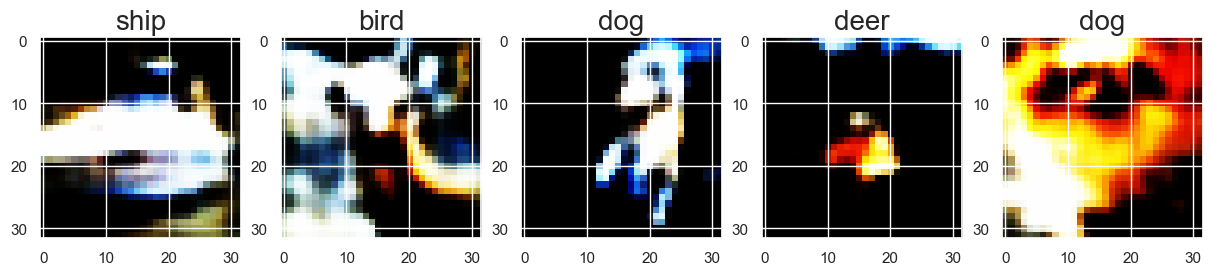

In [38]:
test_output = pretrained_model_denosing(images.to('cuda:0')).cpu()

fig = plt.figure(figsize=(15,3))
for i, img, label in zip(range(5), test_output, labels):
    numpy_img = np.transpose(img.detach().numpy(), (1, 2, 0))
    ax = fig.add_subplot(1, 5, i+1)
    ax.imshow(numpy_img)
    title = classes[int(label)]
    ax.set_title(title, fontsize=20)
plt.show()

## Denosining AE : 사전학습 된 Encoder를 이용하여 Downstream Task 수행
- Transfer Learning(전이 학습)의 개념
- 사전학습 된 인코더를 활용하여 Supervised Learning 수행

In [39]:
def main(device, configs: dict):
    
    # Define Dataset, Dataloader
    dataset = CIFAR10Dataset(data_dir='./data/')   # local: './data/' or colab:'/content/2023_LG_ES_SSL_1/data/',
    
    train_dataset = dataset.get_dataset(mode='train')
    test_dataset = dataset.get_dataset(mode='test')
    
    train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=configs['batch_size'],
            shuffle=True,
            num_workers=configs['num_worker'],
            drop_last=False)
    
    test_loader = DataLoader(
            dataset=test_dataset,
            batch_size=configs['batch_size'],
            shuffle=False,
            num_workers=configs['num_worker'],
            drop_last=False)
    
    # Define encoder, optimizer, linear classifier
    encoder = pretrained_model_denosing.encoder
    
    classifier = nn.Sequential(
        nn.Linear(768, 512),
        nn.ReLU(),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Linear(128, configs['num_class'])
    )

    optimizer = torch.optim.Adam(
        classifier.parameters(), 
        lr=configs['learning_rate'], 
        weight_decay=configs['weight_decay'])
    
    downstream = Downstream(
        device = device,
        encoder=encoder,
        classifier=classifier,
        optimizer=optimizer,
        epochs=configs['epochs'])
    
    supervised_encoder, supervised_classifier = downstream.train_test(train_loader=train_loader,
                                                                        test_loader=test_loader)
    
    return supervised_encoder, supervised_classifier


if __name__ == '__main__':
    device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu') 
    configs = {'batch_size': 256, 'epochs': 20, 
               'learning_rate': 3e-4, 'weight_decay':0,
               'num_class': 10, 'num_worker': 0}
    supervised_model = main(device, configs)

Files already downloaded and verified
Files already downloaded and verified
Epoch: 1 
Loss: 2.599069118499756 
Top1 Train Accuracy: 14.78271484375 
Top1 Test Accuracy: 18.644832611083984 
Top5 Test Accuracy: 68.87394714355469 

Epoch: 2 
Loss: 2.161285877227783 
Top1 Train Accuracy: 20.068359375 
Top1 Test Accuracy: 21.142578125 
Top5 Test Accuracy: 71.34915924072266 

Epoch: 3 
Loss: 2.0922467708587646 
Top1 Train Accuracy: 23.33984375 
Top1 Test Accuracy: 24.545522689819336 
Top5 Test Accuracy: 75.25540924072266 

Epoch: 4 
Loss: 2.0509490966796875 
Top1 Train Accuracy: 26.171875 
Top1 Test Accuracy: 23.490083694458008 
Top5 Test Accuracy: 71.69095611572266 

Epoch: 5 
Loss: 2.0180180072784424 
Top1 Train Accuracy: 27.91748046875 
Top1 Test Accuracy: 28.248947143554688 
Top5 Test Accuracy: 77.69681549072266 

Epoch: 6 
Loss: 1.9738953113555908 
Top1 Train Accuracy: 29.77294921875 
Top1 Test Accuracy: 30.434946060180664 
Top5 Test Accuracy: 79.55228424072266 

Epoch: 7 
Loss: 1.957860